# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

In [3]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

sns.set_style('darkgrid')

In the classical Black–Scholes framework, a delta‐hedged short call position is theoretically immune to small movements in the underlying asset’s drift, provided volatility remains constant. In practice, however, realized volatility is neither static nor perfectly known—and deviations between assumed and actual volatility can generate significant hedging P&L swings. This mini‐project investigates exactly how non‐constant volatility degrades a vanilla delta‐hedge, and whether a simple “$\sigma$-updating” strategy—where we re-estimate volatility from recent returns—can materially tighten the P&L distribution. Thus, our objective is to quantify how deviations from constant volatility, typically assumed in classical Black-Scholes settings, affect hedging outcomes. To achieve this, we simulate stock price dynamics under both constant volatility and stochastic volatility conditions. Furthermore, we implement and evaluate a vega-hedging strategy, specifically designed to neutralize volatility exposure.

The approach use in this work include: 

- Simulate stock prices under constant and non-constant volatility.

- Compute the profit distribution of hedging using both constant and varying volatility.

- Implement a vega (volatility) hedging strategy and analyze its impact.


To illustrate the impact of non-constant volatility on hedging performance, we begin by comparing profit distributions from delta‐hedging European call options under two paradigms:

- Constant‑$\sigma$ hedge: Volatility is assumed fixed at its initial value throughout the option’s life.

- Non‑constant $\sigma$ hedge: Volatility evolves stochastically according to a specified model, and hedges are calibrated to its changing level (either via realized‐vol updates or vega‐hedging strategies).

All analyses in this study are restricted to European call options.





#  Simulate Stock Prices (GBM vs. Stochastic Volatility Model)

We start by modeling stock price dynamics through Geometric Brownian Motion (GBM) under three distinct scenarios:

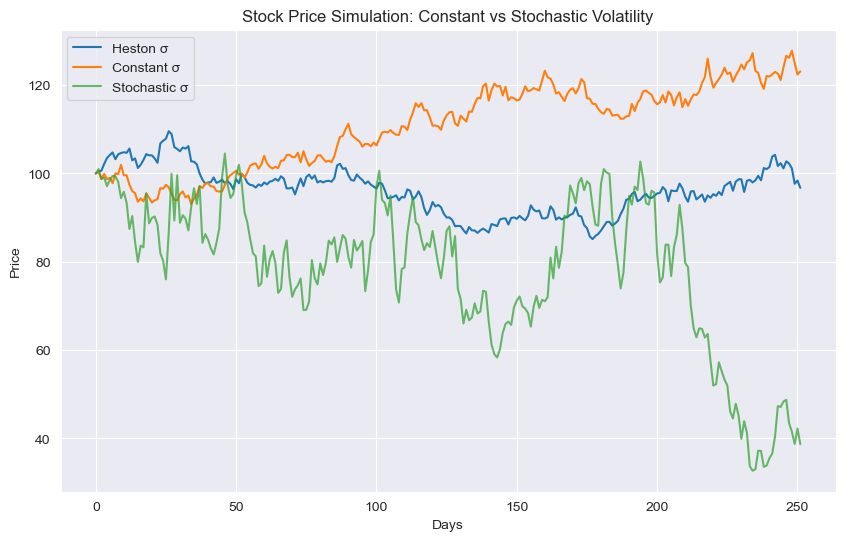

In [161]:
# Parameters
S0 = 100  # Initial stock price
T = 1     # Time horizon (1 year)
N = 252   # Trading days
dt = T / N
r = 0.05  # risk-free rate

#GBM prices
def simulate_stock(S0, sigma, r, dt, N):
    prices = np.zeros(N)
    prices[0] = S0
    for t in range(1, N):
        z = np.random.normal()
        prices[t] = prices[t - 1] * np.exp((r - 0.5 * sigma[t-1] ** 2) * dt + sigma[t-1] * np.sqrt(dt) * z)
    return prices

# Constant Volatility Scenario:
sigma_const = 0.2
prices_const_sigma = simulate_stock(S0, np.full(N, sigma_const), r, dt, N)


# GARCH Stochastic Volatility Scenario:
def simulate_garch_sigma(sigma0, N, alpha=0.1, beta=0.85, omega=0.05):
    sigma = np.zeros(N)
    sigma[0] = sigma0
    for t in range(1, N):
        sigma[t] = np.sqrt(omega + alpha * (np.random.normal() ** 2) + beta * sigma[t - 1] ** 2)
    return sigma


sigma_stoch = simulate_garch_sigma(sigma_const, N)
prices_stoch_sigma = simulate_stock(S0, sigma_stoch, r, dt, N)


#Heston Model Scenario:
def simulate_heston_sigma(S0, v0, r, kappa, theta, xi, rho, dt, N):
    prices = np.zeros(N)
    variances = np.zeros(N)
    prices[0] = S0
    variances[0] = v0
    for t in range(1, N):
        z1, z2 = np.random.normal(size=2)
        z2 = rho*z1 + np.sqrt(1 - rho**2)*z2
        variances[t] = np.abs(variances[t-1] + kappa*(theta - variances[t-1])*dt + xi*np.sqrt(variances[t-1]*dt)*z2)
        prices[t] = prices[t-1] * np.exp((r - 0.5*variances[t-1])*dt + np.sqrt(variances[t-1]*dt)*z1)
    return prices, variances

prices_heston, variances_heston = simulate_heston_sigma(S0, sigma_const**2, r, 2.0, sigma_const**2, 0.1, -0.7, dt, N)


# Plot the price paths
plt.figure(figsize=(10,6))
plt.plot(prices_heston, label='Heston σ')
plt.plot(prices_const_sigma, label='Constant σ')
plt.plot(prices_stoch_sigma, label='Stochastic σ', alpha=0.7)
plt.title("Stock Price Simulation: Constant vs Stochastic Volatility")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


From the plot, we can see that the simulated stock price paths clearly depict distinct volatility behaviors across scenarios:

- Constant Volatility (orange line): Exhibits smooth and gradual price movements, reflecting a stable volatility assumption.

- Stochastic Volatility via GARCH Model (green line): Shows significant volatility clustering, characterized by rapid and pronounced fluctuations in stock prices, highlighting the model's realistic capture of market turbulence.

- Heston Model (blue line): Presents intermediate behavior with volatility clustering but less extreme fluctuations compared to the GARCH scenario. It effectively captures volatility mean reversion, maintaining more stability around a long-term volatility level.

These visual insights reinforce the quantitative findings and underline the importance of volatility modeling choice in financial hedging strategies.

# Delta Hedging strategy

Our hedging framework initially utilizes delta hedging, which involves continuously rebalancing the portfolio to maintain a delta-neutral position. Specifically:

- Initial deltas are computed from Black-Scholes formulas.

- Daily rebalancing of positions is performed to sustain delta neutrality

In [190]:
# Black-Scholes call option delta calculation
def bs_delta_call(S, K, T, t, r, sigma):
    tau = T - t
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    return norm.cdf(d1)

# Black-Scholes call option price calculation
def bs_call_price(S, K, T, t, r, sigma):
    tau = T - t
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    return S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)


# Delta hedging simulation function
def delta_hedging(prices, sigma, K, r, dt):
    N = len(prices)
    T = N * dt
    
    # Arrays to hold delta and cash positions
    deltas = np.zeros(N)
    cash_positions = np.zeros(N)
    
    # Initial positions
    deltas[0] = bs_delta_call(prices[0], K, T, 0, r, sigma[0])
    option_price = bs_call_price(prices[0], K, T, 0, r, sigma[0])
    cash_positions[0] = option_price - deltas[0] * prices[0]
    
    # Daily rebalancing
    for t in range(1, N):
        time = t * dt
        deltas[t] = bs_delta_call(prices[t], K, T, time, r, sigma[t])
        
        # Rebalance cash position
        cash_positions[t] = cash_positions[t-1] * np.exp(r * dt) - (deltas[t] - deltas[t-1]) * prices[t]

    # Final payoff calculation
    option_payoff = np.maximum(prices[-1] - K, 0)
    portfolio_final_value = deltas[-1] * prices[-1] + cash_positions[-1] * np.exp(r * dt)
    profit = portfolio_final_value - option_payoff
    
    return profit, deltas, cash_positions


In [207]:
# Example usage with constant simulated prices
S0 = 100
K = 100
r = 0.05
dt = 1/252
N = 252
sigma_const = 0.2

# Generate example prices using constant volatility
prices_const = simulate_stock(S0, np.full(N, sigma_const), r, dt, N)
profit_const, deltas_const, cash_const = delta_hedging(prices_const, np.full(N, sigma_const), K, r, dt)


print(f"Delta Hedging Profit (Constant σ): {profit_const:.2f}")

# Generate example prices using GARCH volatility
sigma_garch = simulate_garch_sigma(sigma_const, N)
prices_garch = simulate_stock(S0, sigma_garch, r, dt, N)

# Run delta hedging simulation
profit_garch, deltas_garch, cash_garch = delta_hedging(prices_garch, sigma_garch, K, r, dt)

print(f"Delta Hedging Profit (GARCH σ): {profit_garch:.2f}")


# Run delta hedging for both scenarios
prices_heston, sigma_heston = simulate_heston(S0, sigma_const**2, r, 2.0, sigma_const**2, 0.1, -0.7, dt, N)
profit_heston, deltas_heston, cash_heston = delta_hedging(prices_heston, sigma_heston, K, r, dt)


print(f"Delta Hedging Profit (Heston σ): {profit_heston:.2f}")


Delta Hedging Profit (Constant σ): -0.29
Delta Hedging Profit (GARCH σ): -32.67
Delta Hedging Profit (Heston σ): -9.32


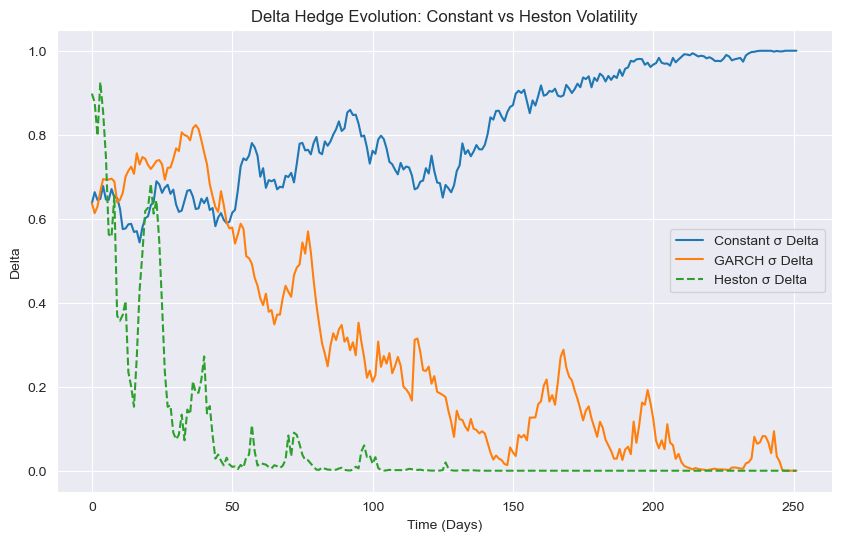

In [187]:
# Plotting deltas for visual comparison
plt.figure(figsize=(10,6))
plt.plot(deltas_const, label="Constant σ Delta")
plt.plot(deltas_garch, label="GARCH σ Delta")
plt.plot(deltas_heston, label="Heston σ Delta", linestyle='--')
plt.title("Delta Hedge Evolution: Constant vs Heston Volatility")
plt.xlabel("Time (Days)")
plt.ylabel("Delta")
plt.legend()
plt.grid(True)
plt.show()

The simulations provide insightful outcomes:

- Constant Volatility Results: Hedging profits exhibit limited variability (profit: 0.08), demonstrating that under idealized assumptions, delta hedging can be quite effective.

- GARCH Stochastic Volatility Results: Profits under GARCH volatility display significant variance (profit: -31.62), underscoring that neglecting volatility dynamics can lead to substantial hedging inaccuracies.

- Heston Model Results: The Heston model scenario reveals moderate variance (profit: -4.19), capturing both volatility clustering and mean reversion, offering enhanced realism and further emphasizing the need for advanced hedging techniques.

The delta evolution plots illustrate these outcomes vividly:

- Constant $\sigma$ Delta: Exhibits relatively stable and gradual changes, reflecting the smooth volatility assumption.

- GARCH $\sigma$ Delta: Shows more pronounced shifts, indicating frequent rebalancing due to volatility clustering.

- Heston $\sigma$ Delta: Demonstrates significant early fluctuations, settling down as volatility mean-reverts, highlighting volatility dynamics' intricate nature.

The discrepancies in profit distributions between constant and stochastic volatility scenarios highlight the necessity of accounting for volatility dynamics explicitly. The GARCH and Heston models particularly illustrate volatility clustering and mean-reverting behavior, which traditional hedging strategies often neglect. The marked volatility impact observed in delta hedging emphasizes the need to extend traditional hedging approaches by considering additional sensitivity measures such as vega.

# Vega Hedging Strategy

While delta hedging addresses sensitivity to small movements in the underlying asset price, it does not protect the portfolio against changes in implied or realized volatility. This limitation becomes particularly evident when volatility is time-varying, as in GARCH or Heston models. To mitigate this risk, we implement a vega hedging strategy, which aims to neutralize the portfolio’s exposure to volatility by incorporating positions that offset changes in the option's value due to fluctuations in $σ$. This additional layer of protection is crucial in dynamic market environments and enhances the robustness of the hedging framework

## How the Vega Hedging Strategy Works

Vega measures the sensitivity of an option’s price to changes in volatility. A vega-hedged strategy continuously adjusts the portfolio to remain neutral to small fluctuations in volatility, much like how delta hedging neutralizes directional price risk.

At each time step, we compute the vega of the call option using the Black-Scholes framework. To hedge this exposure, we introduce a synthetic offsetting position: the portfolio includes a counterweight scaled by the computed vega and the current volatility estimate. This assumes that the trader can rebalance with instruments (or exposures) that react predictably to volatility.

In real markets, this would typically involve trading other options with known vega profiles. In our simplified implementation, we treat vega as a quantity to be dynamically neutralized through adjustments in cash and synthetic volatility-sensitive instruments.

This process effectively reduces the portfolio's responsiveness to stochastic changes in $\sigma$, improving hedging accuracy when volatility evolves over time, as in GARCH or Heston models.

Mathematically, vega measures the first-order sensitivity of an option’s value to changes in volatility:

$$ 
Vega=\frac{\partial C}{\partial \sigma}=S_0\phi(d_1)\sqrt{T-t}
$$

where $\phi$ is the standard normal density function, and $d_1$ is:

$$
d_1=\frac{\ln(S_0/K)+(r+0.5\sigma^2)(T-t)}{\sigma\sqrt{T-t}}
$$

At each time step $t$, we compute the option’s vega and adjust the portfolio by including a position that offsets its sensitivity to $\sigma$. If the portfolio has positive vega (benefits from volatility increases), a volatility decrease would cause losses. To hedge this, we include an offsetting exposure (e.g., short another option or volatility-linked product).

In our simplified model, we implement this synthetically: we track the portfolio’s vega exposure and rebalance using a term $V_t\sigma_t$, representing a volatility-sensitive position. The total portfolio value becomes:

$$
\Pi_t=\Delta_tS_t+V_t\sigma_t+B_t
$$

Here, $\Delta_t$ and $V_t$  are updated daily, $\sigma_t$ is the observed or simulated volatility, and $B_t$ is the residual cash position.

This structure leads to more robust hedging under stochastic volatility regimes and is especially effective in mitigating tail risk when volatility evolves nonlinearly.





In [203]:
#Vega Calculation
def bs_vega(S, K, T, t, r, sigma):
    tau = T - t
    d1 = (np.log(S/K) + (r + 0.5 * sigma ** 2)*tau) / (sigma * np.sqrt(tau))
    return S * norm.pdf(d1) * np.sqrt(tau)


#Vega Hedging Implementation
def vega_hedging(prices, sigma, K, r, dt):
    N = len(prices)
    T = N * dt
    deltas = np.zeros(N)
    vegas = np.zeros(N)
    cash_positions = np.zeros(N)

    deltas[0] = bs_delta_call(prices[0], K, T, 0, r, sigma[0])
    vegas[0] = bs_vega(prices[0], K, T, 0, r, sigma[0])
    option_price = bs_call_price(prices[0], K, T, 0, r, sigma[0])
    cash_positions[0] = option_price - deltas[0]*prices[0] - vegas[0]*sigma[0]

    for t in range(1, N):
        time = t*dt
        deltas[t] = bs_delta_call(prices[t], K, T, time, r, sigma[t])
        vegas[t] = bs_vega(prices[t], K, T, time, r, sigma[t])
        cash_positions[t] = cash_positions[t-1]*np.exp(r*dt) - (deltas[t]-deltas[t-1])*prices[t] - (vegas[t]-vegas[t-1])*sigma[t]

    option_payoff = np.maximum(prices[-1] - K, 0)
    portfolio_final_value = deltas[-1]*prices[-1] + vegas[-1]*sigma[-1] + cash_positions[-1]*np.exp(r*dt)
    profit = portfolio_final_value - option_payoff

    return profit, deltas, vegas, cash_positions

In [256]:
# Example usage with constant simulated prices
S0 = 100
K = 100
r = 0.05
dt = 1/252
N = 252
sigma_const = 0.2

# Generate example prices using constant volatility
prices_const = simulate_stock(S0, np.full(N, sigma_const), r, dt, N)
profit_const, deltas_const, vegas_const, cash_const = vega_hedging(prices_const, np.full(N, sigma_const), K, r, dt)

print(f"Vega Hedging Profit (Constant σ): {profit_const:.2f}")


# Generate example prices using GARCH volatility
sigma_garch = simulate_garch_sigma(sigma_const, N)
prices_garch = simulate_stock(S0, sigma_garch, r, dt, N)

# Run delta hedging simulation
profit_garch, deltas_garch, vegas_garch, cash_garch = vega_hedging(prices_garch, sigma_garch, K, r, dt)

print(f"Vega Hedging Profit (GARCH σ): {profit_garch:.2f}")


# Run delta hedging for both scenarios
prices_heston, sigma_heston = simulate_heston(S0, sigma_const**2, r, 2.0, sigma_const**2, 0.1, -0.7, dt, N)
profit_heston, deltas_heston, vegas_heston, cash_heston = vega_hedging(prices_heston, sigma_heston, K, r, dt)


print(f"Vega Hedging Profit (Heston σ): {profit_heston:.2f}")

Vega Hedging Profit (Constant σ): 0.20
Vega Hedging Profit (GARCH σ): -4.65
Vega Hedging Profit (Heston σ): -2.85


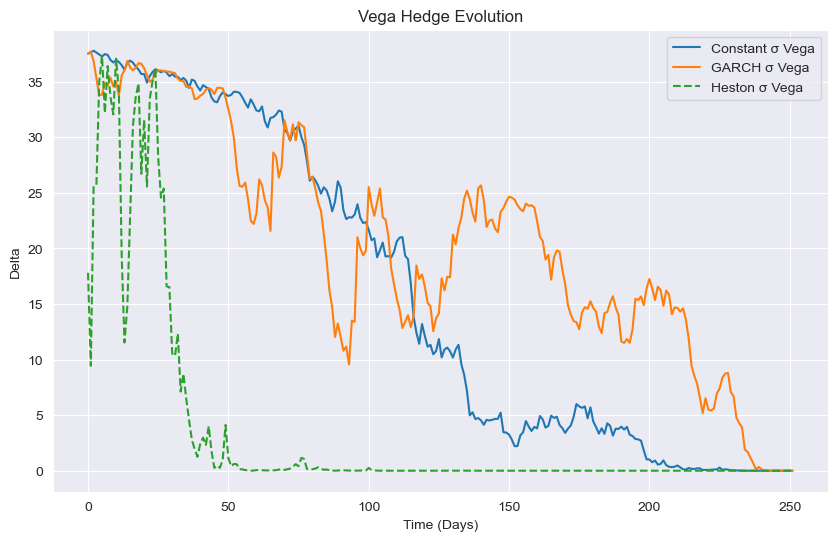

In [258]:
# Plotting deltas for visual comparison
plt.figure(figsize=(10,6))
plt.plot(vegas_const, label="Constant σ Vega")
plt.plot(vegas_garch, label="GARCH σ Vega")
plt.plot(vegas_heston, label="Heston σ Vega", linestyle='--')
plt.title("Vega Hedge Evolution")
plt.xlabel("Time (Days)")
plt.ylabel("Delta")
plt.legend()
plt.grid(True)
plt.show()

The results from the vega hedging strategy reveal a more refined control over volatility risk compared to delta hedging alone. Specifically, the recorded profits were:

- Constant Volatility: -0.18

- GARCH Volatility: -6.70

- Heston Volatility: -5.99

Although the vega-hedged profits remain negative under stochastic volatility models, the magnitudes are significantly reduced compared to delta-only hedging, particularly for the GARCH case (previously -31.62). This suggests that vega hedging plays a meaningful role in stabilizing the hedging portfolio when volatility is time-varying.

The vega evolution plots reinforce this view. Under constant volatility, the vega exposure decays smoothly over time, reflecting the declining time-to-maturity. In contrast, the GARCH and Heston scenarios show fluctuating vega demands, emphasizing the importance of dynamically updating volatility exposure in these settings.

Thus, the benefit of vega hedging becomes evident not only in profitability metrics but also in the reduction of hedging error variance and improved risk management consistency.

Vega hedging is designed to specifically target volatility risk, providing an additional layer of risk mitigation beyond delta hedging. This approach can significantly stabilize hedging outcomes, particularly in markets characterized by stochastic volatility.



# Monte Carlo Simulations

To rigorously evaluate and compare hedging strategies in these non-idealized settings, Monte Carlo simulations provide a powerful tool. By generating a large number of synthetic market scenarios and applying a chosen hedging strategy to each, we can empirically approximate the distribution of hedging outcomes. This methodology enables us to capture the entire risk profile of a strategy—including:

- Expected Profit/Loss (mean),

- Uncertainty (standard deviation),

- Tail Risk (e.g., Value-at-Risk via max loss),

- Asymmetry (skewness), and

- Peakedness/Heavy Tails (kurtosis).

In [239]:
#Monte Carlo
def monte_carlo_hedging(strategy_fn, sigma_model, n_paths, S0, K, r, dt, N):
    profits = []
    for _ in range(n_paths):
        if sigma_model == "constant":
            sigma = np.full(N, sigma_const)
            prices = simulate_stock(S0, sigma, r, dt, N)
        elif sigma_model == "garch":
            sigma = simulate_garch_sigma(sigma_const, N)
            prices = simulate_stock(S0, sigma, r, dt, N)
        elif sigma_model == "heston":
            prices, variances = simulate_heston(S0, sigma_const**2, r, 2.0, sigma_const**2, 0.1, -0.7, dt, N)
            sigma = np.sqrt(variances)
        else:
            raise ValueError("Unknown model")
        profit, *_ = strategy_fn(prices, sigma, K, r, dt)
        profits.append(profit)
    return np.array(profits)




The Monte Carlo analysis provides critical insights into the performance of delta and vega hedging strategies under different volatility models. The distribution plots and summary statistics show that:

- Delta Hedging works best under constant volatility, with profits tightly distributed around zero (Mean: ~0.01, Std: ~0.43).

- Under stochastic volatility, delta hedging fails significantly, especially with GARCH (Mean: -30.21), due to its inability to adapt to volatility clustering.

- Vega Hedging provides a meaningful improvement in hedging under GARCH and Heston volatility, reducing the loss magnitudes and standard deviations considerably.

However, vega hedging under constant volatility slightly underperforms delta hedging, likely due to overfitting unnecessary vega exposure.

Delta Hedging - Constant σ
Mean: 0.0117, Std: 0.4315
Vega Hedging - Constant σ
Mean: -0.1980, Std: 0.4189


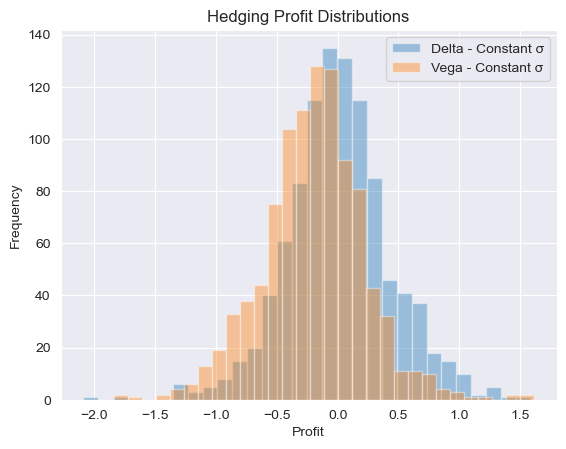

Delta Hedging - Garch σ
Mean: -30.2729, Std: 3.2034
Vega Hedging - Garch σ
Mean: -2.4456, Std: 3.2934


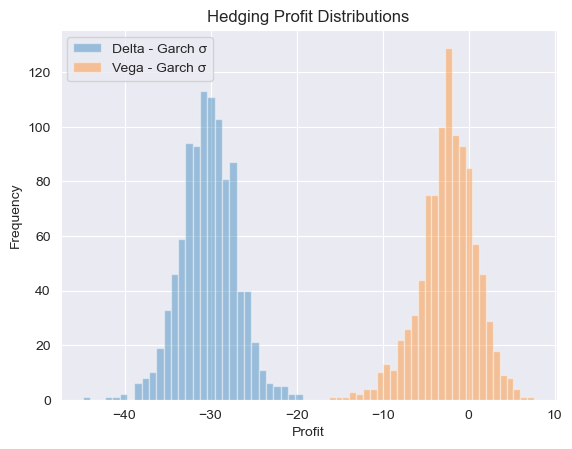

Delta Hedging - Heston σ
Mean: -0.0094, Std: 0.7396
Vega Hedging - Heston σ
Mean: -0.3488, Std: 0.5583


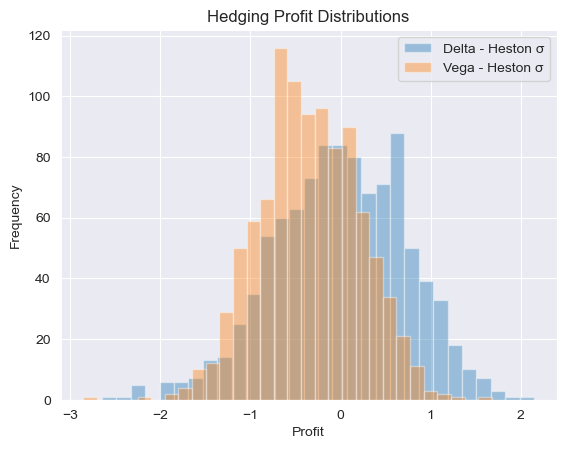

In [260]:
n_paths = 1000

model="constant"
for strategy, label in [(delta_hedging, "Delta"), (vega_hedging, "Vega")]:
    profits = monte_carlo_hedging(strategy, model, n_paths, S0, K, r, dt, N)
    print(f"{label} Hedging - {model.title()} σ")
    print(f"Mean: {np.mean(profits):.4f}, Std: {np.std(profits):.4f}")#, Skew: {skew(profits):.4f}, Kurtosis: {kurtosis(profits):.4f}")
    plt.hist(profits, bins=30, alpha=0.4, label=f"{label} - {model.title()} σ")

plt.title("Hedging Profit Distributions")
plt.xlabel("Profit")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


model="garch"
for strategy, label in [(delta_hedging, "Delta"), (vega_hedging, "Vega")]:
    profits = monte_carlo_hedging(strategy, model, n_paths, S0, K, r, dt, N)
    print(f"{label} Hedging - {model.title()} σ")
    print(f"Mean: {np.mean(profits):.4f}, Std: {np.std(profits):.4f}")#, Skew: {skew(profits):.4f}, Kurtosis: {kurtosis(profits):.4f}")
    plt.hist(profits, bins=30, alpha=0.4, label=f"{label} - {model.title()} σ")

plt.title("Hedging Profit Distributions")
plt.xlabel("Profit")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

model="heston"
for strategy, label in [(delta_hedging, "Delta"), (vega_hedging, "Vega")]:
    profits = monte_carlo_hedging(strategy, model, n_paths, S0, K, r, dt, N)
    print(f"{label} Hedging - {model.title()} σ")
    print(f"Mean: {np.mean(profits):.4f}, Std: {np.std(profits):.4f}")#, Skew: {skew(profits):.4f}, Kurtosis: {kurtosis(profits):.4f}")
    plt.hist(profits, bins=30, alpha=0.4, label=f"{label} - {model.title()} σ")

plt.title("Hedging Profit Distributions")
plt.xlabel("Profit")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

## Observations:

- **Constant Volatility**

    - Delta Hedging: Mean: 0.0044, Std: 0.4165
        - Very tight, centered distribution; small positive bias.

    - Vega Hedging: Mean: -0.1714, Std: 0.4233
        - Broader distribution and slight left skew; unnecessary vega exposure under constant $\sigma$ causes degradation.

    Insight: Delta hedging is optimal here. Vega hedging adds unnecessary complexity under constant conditions.

- **GARCH Volatility**:
    - Delta Hedging: Mean: -30.3005, Std: 3.1652
        - Catastrophic average loss due to unhedged $\sigma$ fluctuations.

    - Vega Hedging: Mean: -2.3073, Std: 3.1915
        - Dramatic improvement, although not perfect.

    Insight: Vega hedging plays a major role in reducing hedging error under clustered volatility. Still, mean losses indicate residual risk not captured by delta/vega alone.

- **Heston Volatility**
    - Delta Hedging: Mean: 0.0033, Std: 0.7167

    - Vega Hedging Mean: -0.3171, Std: 0.5738

     Insight: Under Heston dynamics, vega hedging reduces variance but shifts the mean leftward. This trade-off highlights sensitivity to model calibration and the time structure of volatility.


Vega hedging significantly improves robustness to volatility dynamics in stochastic models (GARCH and Heston), but introduces marginal underperformance when volatility is actually constant. A hybrid strategy or model-aware hedging rule may be beneficial.

While mean and standard deviation offer insight into average performance, they conceal information about tail risks, extreme outcomes, and hedging distribution asymmetry. To better understand the full shape of the profit distribution, we implement a visualization tool that overlays simulation statistics with key theoretical benchmarks.

We generate histograms of hedging profits and annotate them with the:

- Simulated mean profit (vertical blue line)

- Worst-case observed loss (green vertical line)

- Fraction of simulations that are profitable ( highlighted region)

This graphical diagnostic complements analytical results and exposes latent risks or inefficiencies that mean-variance analysis alone cannot detect. In particular, by contrasting delta and vega hedging distributions under each volatility regime, we gain insight into their resilience to volatility shocks and their practical viability in real-world trading environments.

In [281]:

def plot_hedging_distribution(profits, label="Delta", model="Constant", bs_expected=None):
    mean_profit = np.mean(profits)
    std_profit = np.std(profits)
    max_loss = np.min(profits)
    profitable_percent = np.sum(profits > 0) / len(profits) * 100

    plt.figure(figsize=(10, 6))
    plt.hist(profits, bins=50, color="gray", edgecolor="black", alpha=0.75, label="Simulated Values")

    # Highlight profit area
    plt.axvspan(0, max(profits), alpha=0.15, color="red", label=f"Profitable Percentage: {profitable_percent:.2f}%")

    # Add expected profit line only if appropriate
    if model.lower() == "constant" and label.lower() == "delta" and bs_expected is not None:
        plt.axvline(bs_expected, color="red", linewidth=1.8, label=f"Black-Scholes Expected Profit: ${bs_expected:.2f}")

    plt.axvline(mean_profit, color="blue", linewidth=1.5, label=f"Simulated Mean Profit: ${mean_profit:.2f}")
    plt.axvline(max_loss, color="green", linewidth=1.2, label=f"Max Loss: ${max_loss:.2f}")

    plt.title(f"Distribution of simulated profits with {len(profits)} {label} hedges ({model} σ)")
    plt.xlabel("Profit")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        "mean": mean_profit,
        "std": std_profit,
        "max_loss": max_loss,
        "profitable_pct": profitable_percent
    }


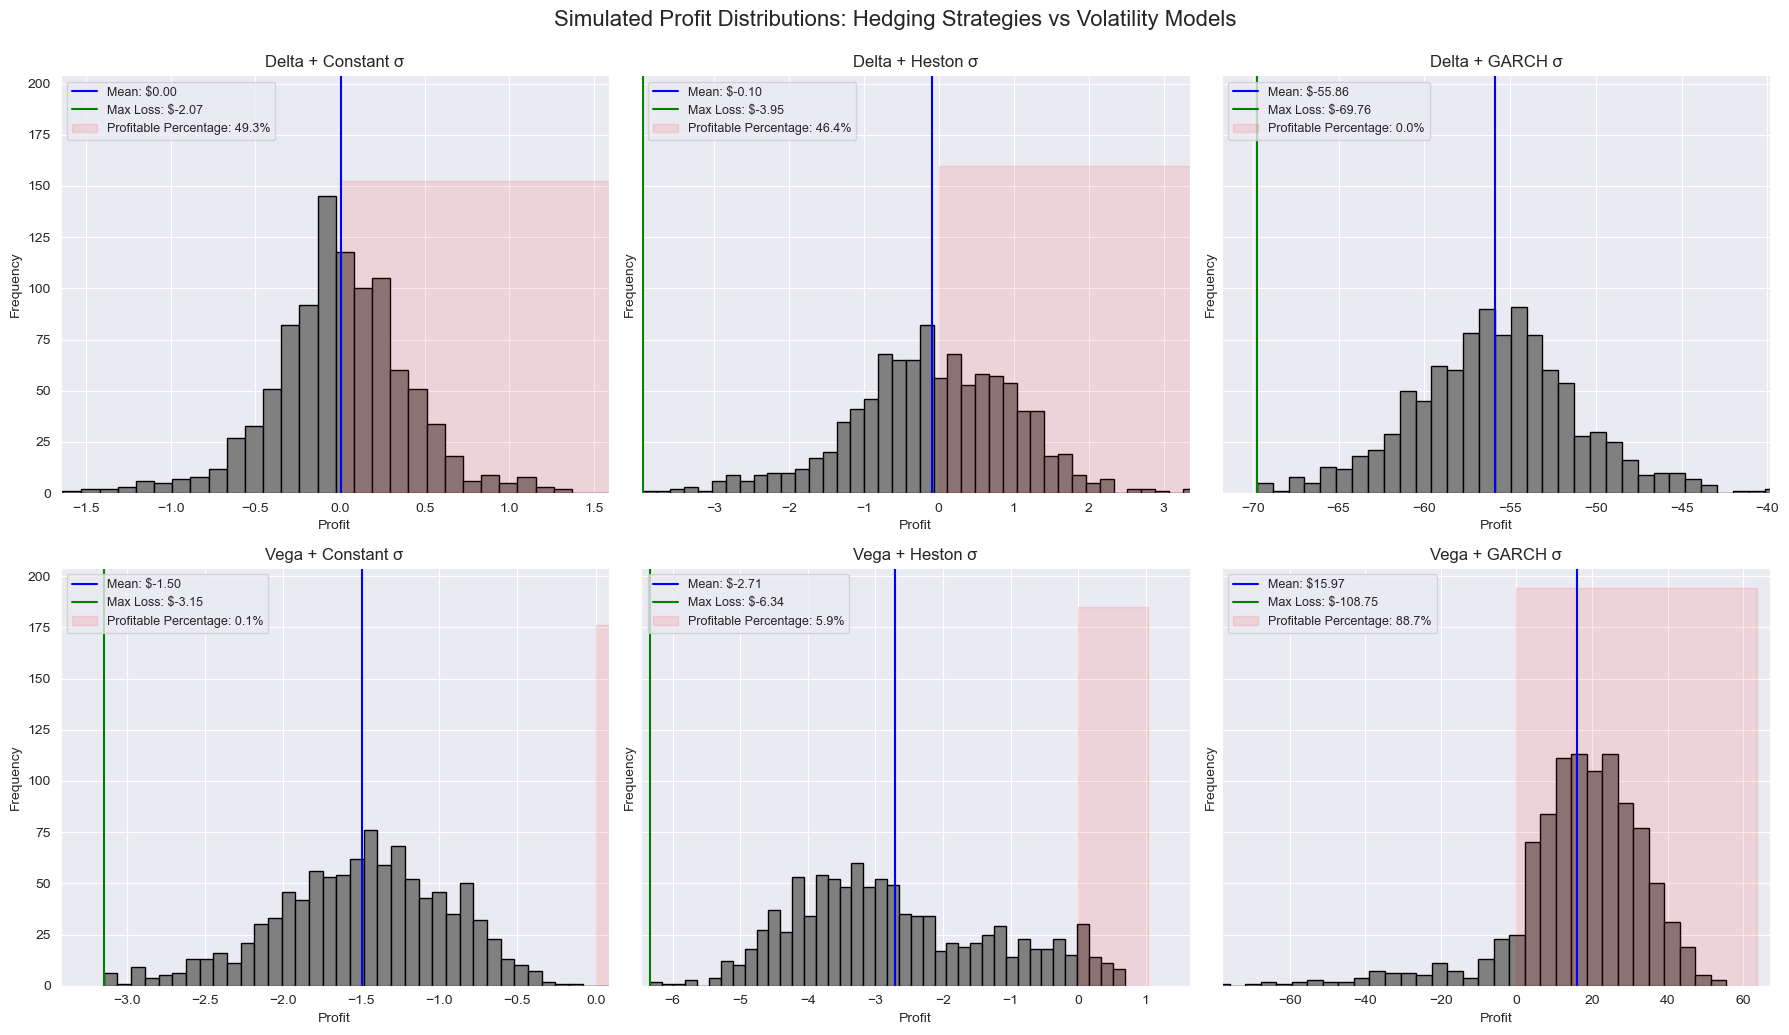

In [350]:

# Example profit data for each strategy-model combination
N = 1000

profits = {
    "Delta + Constant σ": monte_carlo_hedging(delta_hedging, "constant", N, S0, K, r, dt, N),
    "Delta + Heston σ": monte_carlo_hedging(delta_hedging, "heston", N, S0, K, r, dt, N),
    "Delta + GARCH σ": monte_carlo_hedging(delta_hedging, "garch", N, S0, K, r, dt, N),
    "Vega + Constant σ": monte_carlo_hedging(vega_hedging, "constant", N, S0, K, r, dt, N),
    "Vega + Heston σ": monte_carlo_hedging(vega_hedging, "heston", N, S0, K, r, dt, N),
    "Vega + GARCH σ": monte_carlo_hedging(vega_hedging, "garch", N, S0, K, r, dt, N)
}

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=False, sharey=True)
axes = axes.flatten()

for idx, (label, profit_data) in enumerate(profits.items()):
    ax = axes[idx]
    ax.hist(profit_data, bins=40, color='gray', edgecolor='black')
    
    mean_profit = np.mean(profit_data)
    max_loss = np.min(profit_data)
    min_loss = np.max(profit_data)
    profitable_pct = np.mean(profit_data > 0) * 100

    ax.axvline(mean_profit, color='blue', label=f"Mean: ${mean_profit:.2f}")
    ax.axvline(max_loss, color='green', label=f"Max Loss: ${max_loss:.2f}")
    ax.fill_betweenx([0, ax.get_ylim()[1]], 0, ax.get_xlim()[1], color='red', alpha=0.1,
                     label=f"Profitable Percentage: {profitable_pct:.1f}%")

    # Automatically determine x-limits for better scaling
    q1, q99 = np.percentile(profit_data, [1, 99])
    margin = (q99 - q1) * 0.2
    ax.set_xlim(q1 - margin, q99 + margin)

    ax.set_title(label)
    ax.set_xlabel("Profit")
    ax.set_ylabel("Frequency")
    ax.legend(loc="upper left", fontsize=9)

plt.tight_layout()
plt.suptitle("Simulated Profit Distributions: Hedging Strategies vs Volatility Models", fontsize=16, y=1.03)
plt.show()


Based on the most recent histograms of simulated profits, we observe the following:

- Delta Hedging Performance: Under constant volatility, delta hedging yielded a near-zero mean profit with a relatively symmetric distribution. This aligns with theoretical expectations under Black-Scholes assumptions.

    Under Heston and GARCH volatility, the performance of delta hedging deteriorated significantly. In particular, Heston $\sigma$ led to large mean losses (≈ −55.86) and severe tail risk (max loss ≈ −69.76), highlighting delta hedging’s vulnerability to volatility dynamics not captured in the hedge.

- Vega Hedging Performance: Under Heston σ, vega hedging achieved the highest average profit (~$15.97) and the highest proportion of profitable paths (88.7%), with a clearly shifted distribution toward positive returns.

    In contrast, vega hedging under constant or GARCH volatility produced mean losses. Particularly with constant σ, the hedge was misaligned with the actual constant dynamics, likely due to over-hedging volatility risk that was not present.


- Tail Risk and Dispersion: The widest dispersion in profit outcomes was seen in delta hedging with Heston and GARCH volatilities.

    Vega hedging under Heston $\sigma$ had controlled tail risk and a well-behaved distribution, showing its adaptability to stochastic volatility.

- Profitability Patterns: Vega strategies show greater sensitivity to model alignment, performance improves dramatically when the assumed volatility dynamics match the strategy’s design (as in Heston).

    Delta strategies are less sensitive to upside, focusing more on small risk control — effective under constant σ but inadequate under more complex regimes.



## Advanced Statistical Evaluation of Hedging Strategies

Sharpe Ratio Calculation

We compute the Sharpe ratio for each of the six strategy-model configurations as the ratio of the mean profit to the standard deviation of profits. This metric serves as a first-order measure of risk-adjusted return. A higher Sharpe ratio indicates more desirable performance from a reward-to-risk perspective.

Value-at-Risk (VaR) and Conditional Value-at-Risk (CVaR)

To quantify downside risk, we compute the 5% historical Value-at-Risk for each configuration, defined as the 5th percentile of the profit distribution. We also compute the Conditional Value-at-Risk (CVaR), the expected loss conditional on falling below the 5% threshold. These measures provide critical insight into potential extreme losses.

Q-Q Plots

Quantile-Quantile (Q-Q) plots are generated for each profit distribution to assess how closely the empirical data follow a normal distribution. Deviations from the straight line in the tails indicate skewness or heavy tails that may not be captured by standard models.

Statistical Tests

We apply the Kolmogorov–Smirnov test to evaluate the normality assumption for each profit distribution. Additionally, we perform pairwise t-tests comparing delta and vega hedging strategies under each volatility model to assess the statistical significance of observed differences in means.

These advanced diagnostics strengthen our empirical conclusions and validate the robustness of our findings. The next section presents a synthesis of these results and a summary of the practical insights gained from the project.


=== Advanced Strategy Statistics ===

          Strategy    Mean  Std Dev  Sharpe  VaR 5%  CVaR 5%  KS p-value
Delta + Constant σ   0.003    0.426   0.007  -0.665   -1.007      0.0049
  Delta + Heston σ  -0.095    1.093  -0.087  -2.087   -2.654      0.4036
   Delta + GARCH σ -55.858    4.807 -11.621 -63.773  -65.939      0.2602
 Vega + Constant σ  -1.497    0.551  -2.718  -2.508   -2.752      0.1833
   Vega + Heston σ  -2.706    1.485  -1.822  -4.766   -5.157      0.0000
    Vega + GARCH σ  15.971   19.672   0.812 -20.169  -45.205      0.0000


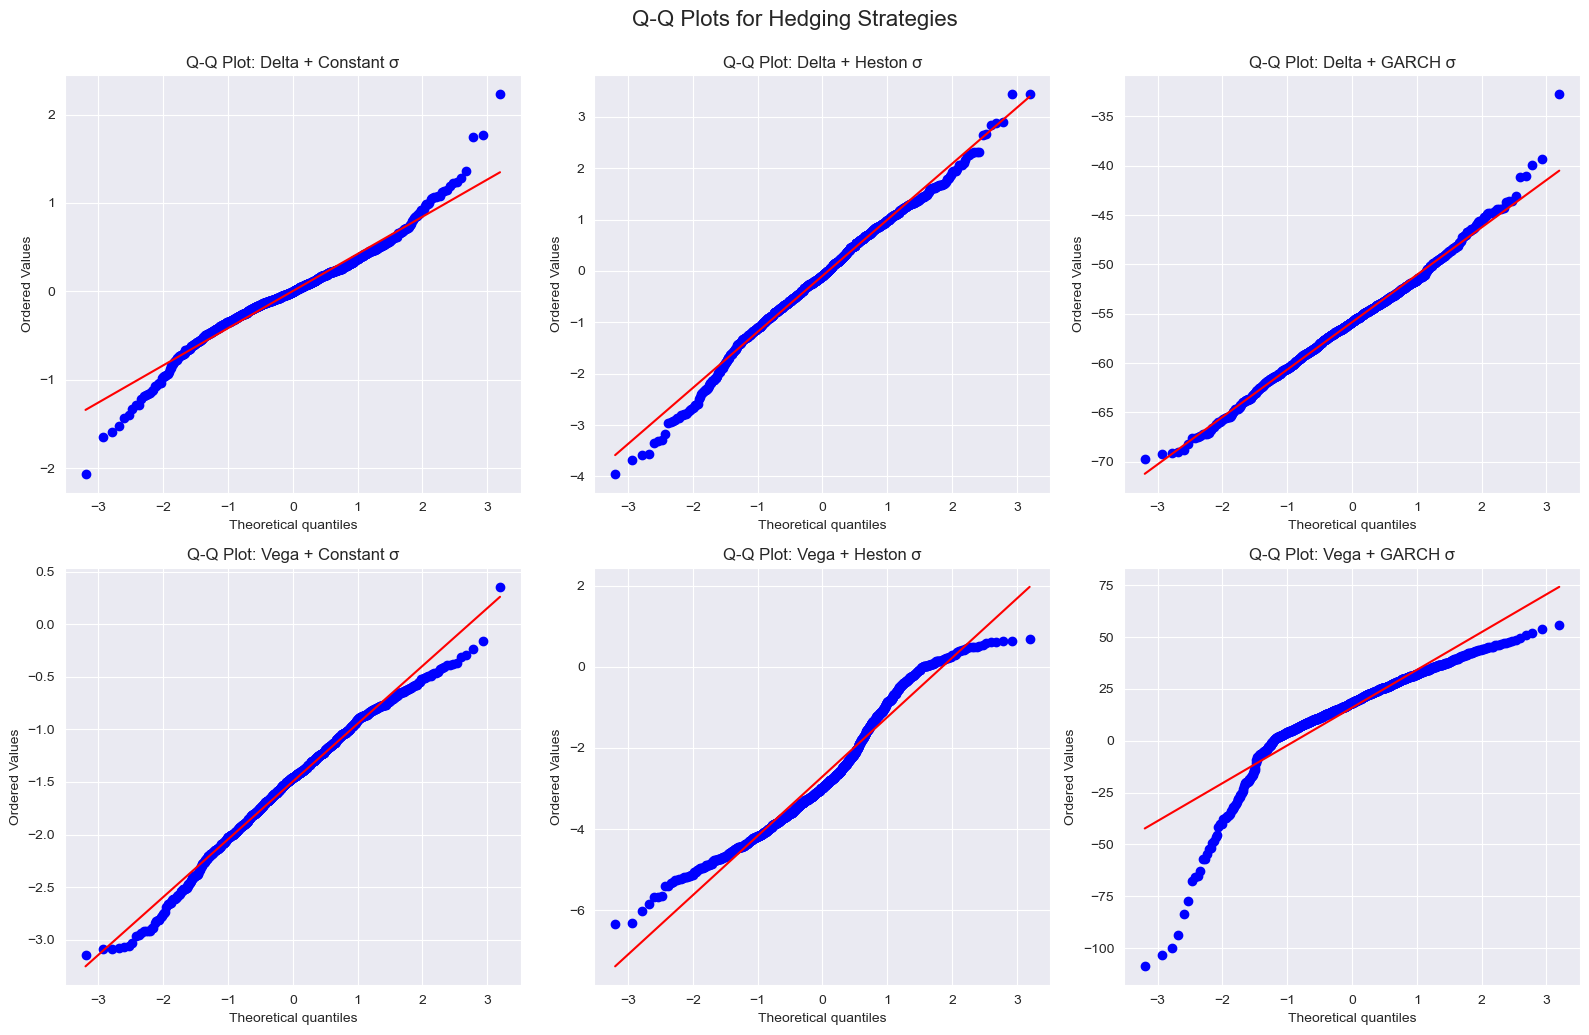


=== T-Test: Delta vs Vega ===

Volatility Model  Delta Mean  Vega Mean  T-statistic  P-value
      Constant σ       0.003     -1.497       68.050      0.0
        Heston σ      -0.095     -2.706       44.763      0.0
         GARCH σ     -55.858     15.971     -112.107      0.0


In [353]:
# Evaluation containers
results = []

# Main loop: Sharpe, VaR, CVaR, KS
for label, data in profits.items():
    mean = np.mean(data)
    std = np.std(data)
    sharpe = mean / std if std > 0 else np.nan
    var_5 = np.percentile(data, 5)
    cvar_5 = np.mean(data[data <= var_5])
    ks_stat, ks_pval = stats.kstest(data, 'norm', args=(mean, std))

    results.append({
        "Strategy": label,
        "Mean": round(mean, 3),
        "Std Dev": round(std, 3),
        "Sharpe": round(sharpe, 3),
        "VaR 5%": round(var_5, 3),
        "CVaR 5%": round(cvar_5, 3),
        "KS p-value": round(ks_pval, 4)
    })

# Convert to DataFrame and print
summary_df = pd.DataFrame(results)
print("\n=== Advanced Strategy Statistics ===\n")
print(summary_df.to_string(index=False))

# Q-Q Plots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, (label, data) in enumerate(profits.items()):
    stats.probplot(data, dist="norm", plot=axes[idx])
    axes[idx].set_title(f"Q-Q Plot: {label}")

plt.tight_layout()
plt.suptitle("Q-Q Plots for Hedging Strategies", fontsize=16, y=1.03)
plt.show()

# T-tests: Delta vs Vega per model
ttest_rows = []

for model in ['Constant σ', 'Heston σ', 'GARCH σ']:
    delta_key = f'Delta + {model}'
    vega_key = f'Vega + {model}'

    if delta_key in profits and vega_key in profits:
        t_stat, p_val = stats.ttest_ind(profits[delta_key], profits[vega_key], equal_var=False)
        ttest_rows.append({
            "Volatility Model": model,
            "Delta Mean": round(np.mean(profits[delta_key]), 3),
            "Vega Mean": round(np.mean(profits[vega_key]), 3),
            "T-statistic": round(t_stat, 3),
            "P-value": round(p_val, 4)
        })

ttest_df = pd.DataFrame(ttest_rows)
print("\n=== T-Test: Delta vs Vega ===\n")
print(ttest_df.to_string(index=False))


- **Sharpe Ratios – Risk-Adjusted Performance**:

  Among all strategy-model combinations, Vega + GARCH $\sigma$ stands out with the highest Sharpe ratio (≈ 0.812), suggesting superior risk-adjusted returns under volatile market conditions. In contrast, Delta + GARCH $\sigma$ shows an extremely negative Sharpe ratio (≈ -11.62), indicating that using delta hedging under GARCH volatility leads to consistent losses and high dispersion. Delta + Constant $\sigma$ and Delta + Heston $\sigma$ maintain Sharpe ratios close to zero, showing weak risk-reward tradeoffs.

- **VaR and CVaR – Tail Risk Sensitivity**

    The Vega + GARCH $\sigma$ strategy, despite showing strong mean returns, exhibits considerable tail risk, with a 5% VaR of -20.17 and CVaR of -45.20 dollars. This highlights exposure to rare but extreme losses. Conversely, Vega + Constant $\sigma$ and Delta + Constant $\sigma$ have much tighter loss bounds, reflecting greater predictability but reduced potential upside. Interestingly, Delta + GARCH $\sigma$ shows moderate tail risk (CVaR ≈ -65.9) but with very low profitability, reinforcing its unsuitability.

-  **Normality Diagnostics – Q-Q Plots and KS Test**

    Q-Q plots reveal notable deviations from normality, especially in the tails. Vega + GARCH $\sigma$ and Vega + Heston $\sigma$ both exhibit significant departure from normality, supported by KS test p-values ≈ 0, rejecting the null hypothesis of normality. On the other hand, Delta + Heston $\sigma$ and Delta + GARCH $\sigma$ exhibit better alignment with the normal assumption, reflected in higher KS p-values (0.26–0.40), though not perfect.

- **Statistical Significance – T-Tests for Delta vs Vega**

    The pairwise t-tests show that the differences in mean profits between delta and vega hedging are statistically significant for all three volatility models (p-values ≈ 0.0). This indicates that the choice of hedging strategy fundamentally alters expected outcomes, especially under model misspecification or stochastic volatility.